In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

import pickle

p=print

In [2]:
"""
Import Data.
"""
SYM='BTC'
Ty=1
Tx=72
channels=28

X_train=np.load('../data/processed/X_train_{}_CWT_{}x{}.npy'.format(SYM, Tx, channels))
y_train=np.load('../data/processed/y_train_{}_CWT_{}x{}.npy'.format(SYM, Tx, channels))
X_test=np.load('../data/processed/X_test_{}_CWT_{}x{}.npy'.format(SYM, Tx, channels))
y_test=np.load('../data/processed/y_test_{}_CWT_{}x{}.npy'.format(SYM, Tx, channels))

In [3]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((15130, 72, 28), (797, 72, 28), (797, 1), (15130, 1))

In [4]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.6704191833149541
mean MSE: 1.1434823688554288

Performance on test data:
mean MAE: 0.27617677289849457
mean MSE: 0.2203102561304603

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.6703710389694876
median MSE: 1.143547094825167

Performance on test data:
median MAE: 0.2768240780719447
median MSE: 0.22082193727421412

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.6709792377853523
constant MSE: 1.143896644909049

Performance on test data:
constant MAE: 0.27555036295581686
constant MSE: 0.21959377436005295


In [5]:
# """
# Reshape the model into a 3D array to fit the RNN Model.
# """
# def shape_model_data(X, n_timesteps, n_features):
#     return X.reshape((X.shape[0], n_timesteps, n_features))


In [6]:
# """
# Define preprocessing steps.
# """
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('reshape', FunctionTransformer(shape_model_data, kw_args=dict(n_timesteps=Tx, n_features=N_FEATURES)))
# ])

In [7]:
# """
# Transform the feature data.
# """
# model_X_train=pipeline.fit_transform(X_train)
# model_X_test=pipeline.fit_transform(X_test)
model_X_train=X_train
model_X_test=X_test

In [8]:
from keras.layers import Input, LSTM, BatchNormalization, Dense, Conv1D, TimeDistributed, Activation
from keras import Model

from keras.initializers import RandomNormal, Ones, Constant

def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'):
    
    model_input = Input(shape=input_shape, dtype='float32')

    X = Conv1D(128, kernel_size=4, strides=1, kernel_initializer=kernel_init, bias_initializer=bias_init)(model_input)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    
    X = LSTM(units=64, return_sequences=True, kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
    X = BatchNormalization(axis=-1)(X)
    
    X = LSTM(units=64, return_sequences=False, kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
    X = BatchNormalization(axis=-1)(X)
    
    X = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear')(X) # time distributed  (linear)
    
    model = Model(inputs=model_input, outputs=X)
    return model


Using TensorFlow backend.


In [9]:
model=lstm_model(model_X_train.shape[1:], Ty)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 28)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 69, 128)           14464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 69, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 69, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 69, 64)            49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, 69, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
__________

In [10]:
from keras.optimizers import Adam
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate=.001
decay_rate = learning_rate / epochs

"""
Compile and fit model.
"""
model.compile(loss='mse', optimizer=Adam(lr=learning_rate, decay=decay_rate), metrics=['mae'])

fit = model.fit(model_X_train, y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(model_X_test, y_test)
               )

Train on 15130 samples, validate on 797 samples
Epoch 1/10
15130/15130 [==============================] - 80s 5ms/step - loss: 0.6461 - mean_absolute_error: 0.5327 - val_loss: 0.1217 - val_mean_absolute_error: 0.2542
Epoch 2/10
15130/15130 [==============================] - 70s 5ms/step - loss: 0.4580 - mean_absolute_error: 0.4500 - val_loss: 0.0933 - val_mean_absolute_error: 0.2154
Epoch 3/10
15130/15130 [==============================] - 70s 5ms/step - loss: 0.4188 - mean_absolute_error: 0.4315 - val_loss: 0.0747 - val_mean_absolute_error: 0.1943
Epoch 4/10
15130/15130 [==============================] - 70s 5ms/step - loss: 0.3902 - mean_absolute_error: 0.4185 - val_loss: 0.0759 - val_mean_absolute_error: 0.1893
Epoch 5/10
15130/15130 [==============================] - 73s 5ms/step - loss: 0.3804 - mean_absolute_error: 0.4134 - val_loss: 0.0655 - val_mean_absolute_error: 0.1794
Epoch 6/10
15130/15130 [==============================] - 73s 5ms/step - loss: 0.3710 - mean_absolute_error

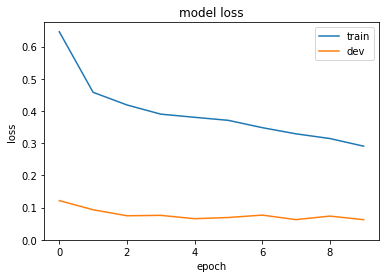

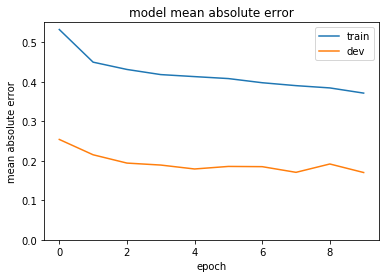

In [11]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

"""
Check out mean absolute error from train and dev sets
"""
plt.plot(fit.history['mean_absolute_error'], label='train')
plt.plot(fit.history['val_mean_absolute_error'], label='dev')
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

In [12]:
backtest=model.predict(model_X_train)
prediction = model.predict(model_X_test)

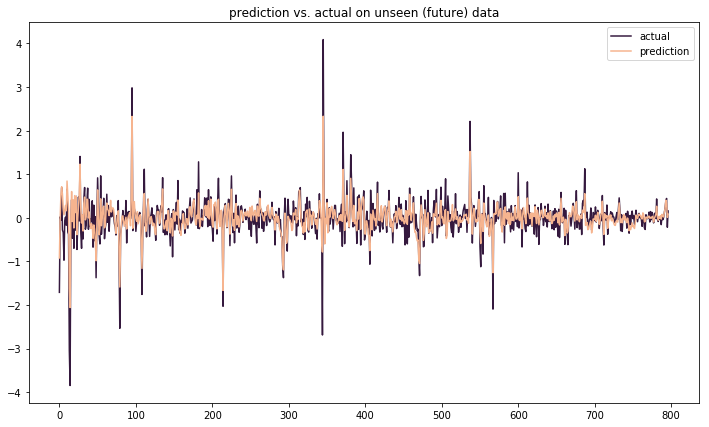

In [13]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()

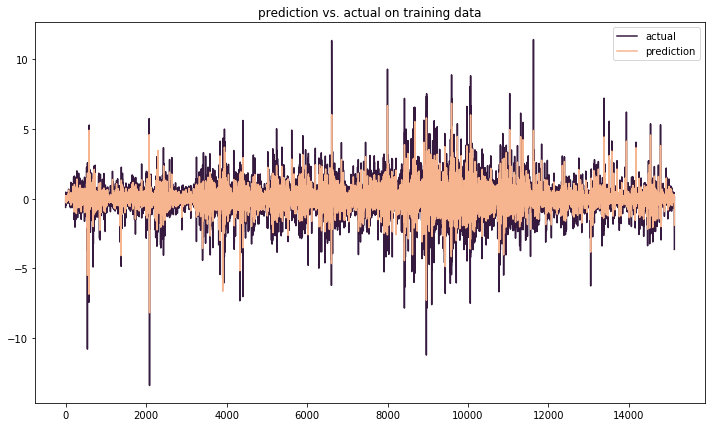

In [14]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()

In [16]:
"""
Save the model.
"""
model.save(filepath='../models/lstm_cwt_72x28_BTC.h5')